Image shape: (255, 270)
Mask shape: (255, 270)
COMPUTING ERRORS FOR D1, STRATEGY 1
Sample sizes - FG: 75, BG: 300
Class priors - FG: 0.2000, BG: 0.8000

Processing alpha = 0.0001
  Error = 0.117894

Processing alpha = 0.0010
  Error = 0.117691

Processing alpha = 0.0100
  Error = 0.117560

Processing alpha = 0.1000
  Error = 0.117502

Processing alpha = 1.0000
  Error = 0.117487

Processing alpha = 10.0000
  Error = 0.117487

Processing alpha = 100.0000
  Error = 0.117487

Processing alpha = 1000.0000
  Error = 0.117487

Processing alpha = 10000.0000
  Error = 0.117487



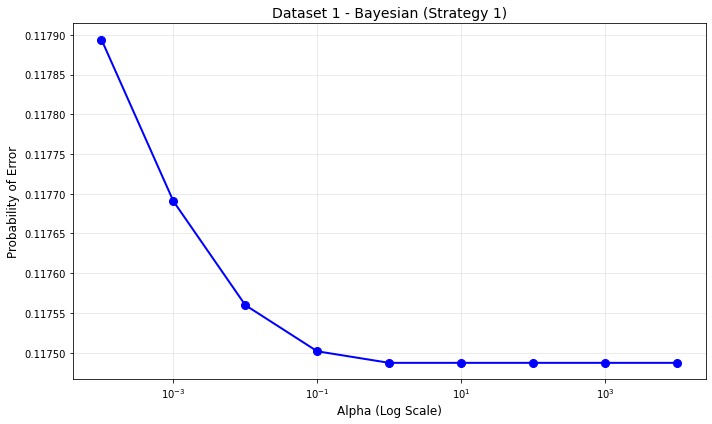


RESULTS TABLE
       Alpha |   P(error)
------------------------------------------------------------
      0.0001 |   0.117894
      0.0010 |   0.117691
      0.0100 |   0.117560
      0.1000 |   0.117502
      1.0000 |   0.117487
     10.0000 |   0.117487
    100.0000 |   0.117487
   1000.0000 |   0.117487
  10000.0000 |   0.117487


In [2]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from PIL import Image
from scipy.fftpack import dct

# Load the data files
alpha_data = sio.loadmat('Alpha.mat')
alpha_values = alpha_data['alpha'].squeeze()

prior1_data = sio.loadmat('Prior_1.mat')
W0 = prior1_data['W0'].squeeze()
mu0_FG = prior1_data['mu0_FG'].squeeze()
mu0_BG = prior1_data['mu0_BG'].squeeze()

training_data = sio.loadmat('TrainingSamplesDCT_subsets_8.mat')
D1_FG = training_data['D1_FG']
D1_BG = training_data['D1_BG']

# Load cheetah image
cheetah_img = np.array(Image.open('cheetah.bmp').convert('L'))
cheetah_mask = np.array(Image.open('cheetah_mask.bmp').convert('L'))

print(f"Image shape: {cheetah_img.shape}")
print(f"Mask shape: {cheetah_mask.shape}")

def dct_8x8_blocks(image):
    """Compute 8x8 DCT for all blocks in image"""
    h, w = image.shape
    dct_blocks = []
    positions = []
    
    for i in range(h-7):
        for j in range(w-7):
            block = image[i:i+8, j:j+8]
            dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')
            dct_blocks.append(dct_block)
            positions.append((i, j))
    
    return dct_blocks, positions

def zigzag_scan(block):
    """Zigzag scan of 8x8 block to get 64-dimensional vector"""
    zigzag_indices = np.array([
        0,  1,  8, 16,  9,  2,  3, 10,
       17, 24, 32, 25, 18, 11,  4,  5,
       12, 19, 26, 33, 40, 48, 41, 34,
       27, 20, 13,  6,  7, 14, 21, 28,
       35, 42, 49, 56, 57, 50, 43, 36,
       29, 22, 15, 23, 30, 37, 44, 51,
       58, 59, 52, 45, 38, 31, 39, 46,
       53, 60, 61, 54, 47, 55, 62, 63
    ])
    return block.flatten()[zigzag_indices]

def compute_bayesian_parameters(X, mu0, W0, alpha):
    """
    Compute Bayesian posterior parameters for Gaussian with known covariance
    
    CRITICAL: The class-conditional covariance Σ is the sample covariance
              The prior covariance Σ₀ = diag(α*w₁, α*w₂, ..., α*w₆₄)
    
    Parameters:
    X: training data (n x d)
    mu0: prior mean (d,)
    W0: weights for prior covariance diagonal (d,)
    alpha: hyperparameter scaling the prior covariance
    
    Returns:
    mu_n: posterior mean
    Sigma_n: posterior covariance
    Sigma: class-conditional covariance (sample covariance)
    """
    n, d = X.shape
    
    # Sample mean (ML estimate)
    mu_ml = np.mean(X, axis=0)
    
    # Σ: Class-conditional covariance (sample covariance)
    Sigma = np.cov(X.T, bias=True)  # Use bias=True for ML estimate
    Sigma += 1e-6 * np.eye(d)  # Add small regularization
    
    # Σ₀: Prior covariance = diag(α*w₁, ..., α*w₆₄)
    # CRITICAL FIX: Σ₀ = α * diag(W0), NOT diag(W0/α)
    Sigma0 = alpha * np.diag(W0)
    
    # Compute inverses
    Sigma_inv = np.linalg.inv(Sigma)
    Sigma0_inv = np.linalg.inv(Sigma0)  # = (1/α) * diag(1/W0)
    
    # Posterior covariance: Σₙ = (Σ₀⁻¹ + n*Σ⁻¹)⁻¹
    Sigma_n_inv = Sigma0_inv + n * Sigma_inv
    Sigma_n = np.linalg.inv(Sigma_n_inv)
    
    # Posterior mean: μₙ = Σₙ * (Σ₀⁻¹*μ₀ + n*Σ⁻¹*μ_ML)
    mu_n = Sigma_n @ (Sigma0_inv @ mu0 + n * Sigma_inv @ mu_ml)
    
    return mu_n, Sigma_n, Sigma

def compute_predictive_parameters(mu_n, Sigma_n, Sigma):
    """
    Compute predictive distribution: p(x*|D) = N(μₙ, Σₙ + Σ)
    """
    mu_pred = mu_n
    Sigma_pred = Sigma_n + Sigma
    Sigma_pred += 1e-6 * np.eye(len(mu_n))  # Regularization
    
    return mu_pred, Sigma_pred

def classify_image(cheetah_img, mu_pred_FG, Sigma_pred_FG, mu_pred_BG, Sigma_pred_BG, prior_FG, prior_BG):
    """
    Classify image using Bayesian decision rule
    """
    h, w = cheetah_img.shape
    predicted = np.zeros((h, w))
    
    # Compute DCT blocks
    dct_blocks, positions = dct_8x8_blocks(cheetah_img)
    
    # Create multivariate normal distributions
    mvn_FG = multivariate_normal(mean=mu_pred_FG, cov=Sigma_pred_FG, allow_singular=True)
    mvn_BG = multivariate_normal(mean=mu_pred_BG, cov=Sigma_pred_BG, allow_singular=True)
    
    # Classify each block
    for idx, (i, j) in enumerate(positions):
        dct_vec = zigzag_scan(dct_blocks[idx])
        
        # Compute log posteriors
        log_post_FG = mvn_FG.logpdf(dct_vec) + np.log(prior_FG)
        log_post_BG = mvn_BG.logpdf(dct_vec) + np.log(prior_BG)
        
        # Classify: 1 for cheetah (FG), 0 for grass (BG)
        predicted[i, j] = 1 if log_post_FG > log_post_BG else 0
    
    return predicted

def compute_error_vs_alpha(alpha_values, D_FG, D_BG, mu0_FG, mu0_BG, W0, 
                           cheetah_img, cheetah_mask):
    """
    Compute probability of error for each alpha value
    """
    errors = []
    
    # ML class priors
    n_FG = D_FG.shape[0]
    n_BG = D_BG.shape[0]
    prior_FG = n_FG / (n_FG + n_BG)
    prior_BG = n_BG / (n_FG + n_BG)
    
    print(f"Sample sizes - FG: {n_FG}, BG: {n_BG}")
    print(f"Class priors - FG: {prior_FG:.4f}, BG: {prior_BG:.4f}\n")
    
    for alpha in alpha_values:
        print(f"Processing alpha = {alpha:.4f}")
        
        # Compute Bayesian posterior for FG
        mu_n_FG, Sigma_n_FG, Sigma_FG = compute_bayesian_parameters(D_FG, mu0_FG, W0, alpha)
        
        # Compute Bayesian posterior for BG
        mu_n_BG, Sigma_n_BG, Sigma_BG = compute_bayesian_parameters(D_BG, mu0_BG, W0, alpha)
        
        # Compute predictive distributions
        mu_pred_FG, Sigma_pred_FG = compute_predictive_parameters(mu_n_FG, Sigma_n_FG, Sigma_FG)
        mu_pred_BG, Sigma_pred_BG = compute_predictive_parameters(mu_n_BG, Sigma_n_BG, Sigma_BG)
        
        # Classify image
        predicted = classify_image(cheetah_img, mu_pred_FG, Sigma_pred_FG, 
                                   mu_pred_BG, Sigma_pred_BG, prior_FG, prior_BG)
        
        # Compute error
        h_min = min(predicted.shape[0], cheetah_mask.shape[0])
        w_min = min(predicted.shape[1], cheetah_mask.shape[1])
        
        predicted_crop = predicted[:h_min, :w_min]
        mask_crop = cheetah_mask[:h_min, :w_min]
        mask_binary = (mask_crop > 127).astype(int)
        
        error = np.sum(predicted_crop != mask_binary) / (h_min * w_min)
        errors.append(error)
        print(f"  Error = {error:.6f}\n")
    
    return np.array(errors)

# Compute errors for D1
print("="*60)
print("COMPUTING ERRORS FOR D1, STRATEGY 1")
print("="*60)
errors_D1 = compute_error_vs_alpha(alpha_values, D1_FG, D1_BG, mu0_FG, mu0_BG, W0,
                                    cheetah_img, cheetah_mask)

# Plot results
plt.figure(figsize=(10, 6))
plt.semilogx(alpha_values, errors_D1, 'b-', linewidth=2, marker='o', markersize=8)
plt.xlabel('Alpha (Log Scale)', fontsize=12)
plt.ylabel('Probability of Error', fontsize=12)
plt.title('Dataset 1 - Bayesian (Strategy 1)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('D1_bayesian_strategy1_corrected.png', dpi=300, bbox_inches='tight')
plt.show()

# Print results table
print("\n" + "="*60)
print("RESULTS TABLE")
print("="*60)
print(f"{'Alpha':>12} | {'P(error)':>10}")
print("-" * 60)
for alpha, error in zip(alpha_values, errors_D1):
    print(f"{alpha:12.4f} | {error:10.6f}")


Loading data files...
Alpha values: [1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
Prior mean FG (first 5): [1. 0. 0. 0. 0.]
Prior mean BG (first 5): [3. 0. 0. 0. 0.]
W0 (first 5): [1.         0.73791018 0.76135559 0.64179768 0.64946151]

Data mean FG D1 (first 5): [ 1.32921569  0.0266366  -0.03807374  0.00884253 -0.01769065]
Data mean BG D1 (first 5): [ 2.93162092e+00  3.80009327e-03 -7.64129490e-03 -5.44701894e-03
  7.58150643e-04]

Image shape: (255, 270)
Mask shape: (255, 270)


D1 (75 FG, 300 BG)
n_FG=75, n_BG=300, ML Error=0.134089

  α=    0.0001 | Pred:0.117894 | MAP:0.134103
  α=    0.0010 | Pred:0.117691 | MAP:0.134103
  α=    0.0100 | Pred:0.117560 | MAP:0.134089
  α=    0.1000 | Pred:0.117502 | MAP:0.134089
  α=    1.0000 | Pred:0.117487 | MAP:0.134089
  α=   10.0000 | Pred:0.117487 | MAP:0.134089
  α=  100.0000 | Pred:0.117487 | MAP:0.134089
  α= 1000.0000 | Pred:0.117487 | MAP:0.134089
  α=10000.0000 | Pred:0.117487 | MAP:0.134089

D2 (125 FG, 500 BG)
n_

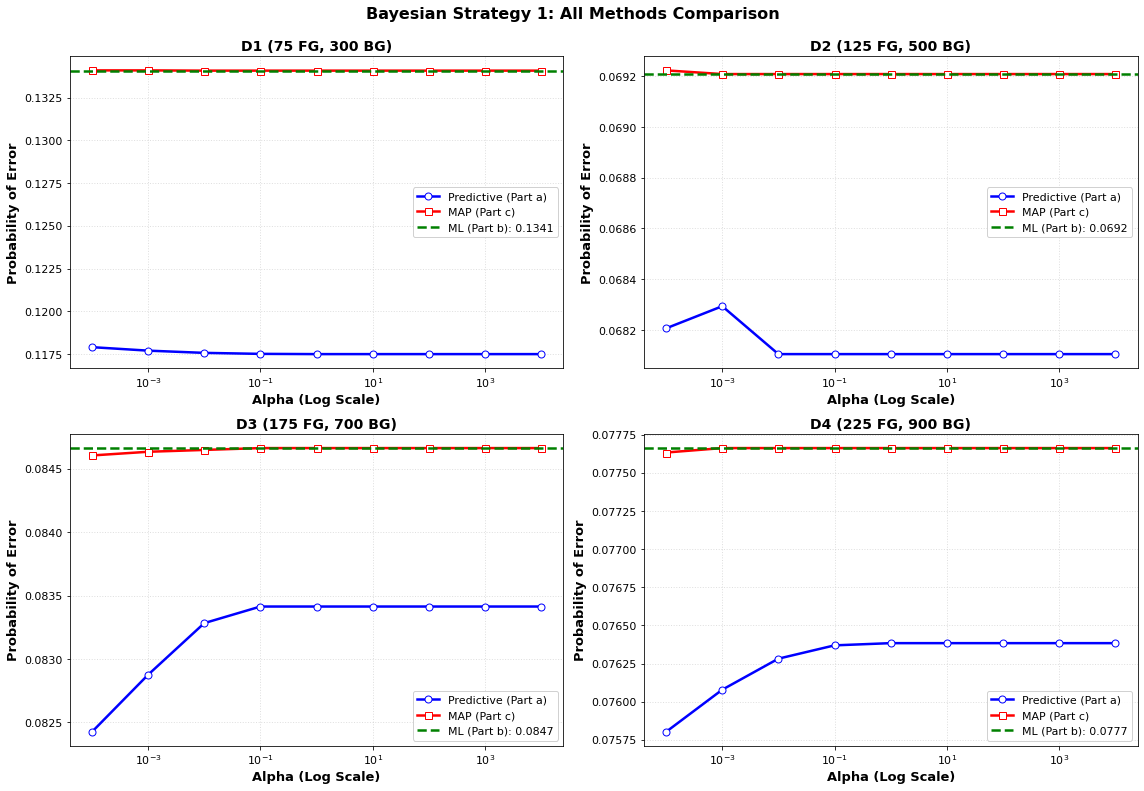


COMPLETE!


In [4]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from PIL import Image
from scipy.fftpack import dct

# ============================================================================
# LOAD DATA
# ============================================================================
print("Loading data files...")
alpha_data = sio.loadmat('Alpha.mat')
alpha_values = alpha_data['alpha'].squeeze()
print(f"Alpha values: {alpha_values}")

prior1_data = sio.loadmat('Prior_1.mat')
W0 = prior1_data['W0'].squeeze()
mu0_FG = prior1_data['mu0_FG'].squeeze().astype(float)
mu0_BG = prior1_data['mu0_BG'].squeeze().astype(float)

print(f"Prior mean FG (first 5): {mu0_FG[:5]}")
print(f"Prior mean BG (first 5): {mu0_BG[:5]}")
print(f"W0 (first 5): {W0[:5]}")

training_data = sio.loadmat('TrainingSamplesDCT_subsets_8.mat')
D1_FG = training_data['D1_FG']
D1_BG = training_data['D1_BG']
D2_FG = training_data['D2_FG']
D2_BG = training_data['D2_BG']
D3_FG = training_data['D3_FG']
D3_BG = training_data['D3_BG']
D4_FG = training_data['D4_FG']
D4_BG = training_data['D4_BG']

# Check actual means from data
print(f"\nData mean FG D1 (first 5): {D1_FG.mean(axis=0)[:5]}")
print(f"Data mean BG D1 (first 5): {D1_BG.mean(axis=0)[:5]}")

# Load cheetah image and mask
cheetah_img = np.array(Image.open('cheetah.bmp').convert('L'))
cheetah_mask = np.array(Image.open('cheetah_mask.bmp').convert('L'))

print(f"\nImage shape: {cheetah_img.shape}")
print(f"Mask shape: {cheetah_mask.shape}\n")

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def dct_8x8_blocks(image):
    """Compute 8x8 DCT for all blocks in image"""
    h, w = image.shape
    dct_blocks = []
    positions = []
    
    for i in range(h-7):
        for j in range(w-7):
            block = image[i:i+8, j:j+8].astype(float)
            dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')
            dct_blocks.append(dct_block)
            positions.append((i, j))
    
    return dct_blocks, positions

def zigzag_scan(block):
    """Zigzag scan of 8x8 block to get 64-dimensional vector"""
    zigzag_indices = np.array([
        0,  1,  8, 16,  9,  2,  3, 10,
       17, 24, 32, 25, 18, 11,  4,  5,
       12, 19, 26, 33, 40, 48, 41, 34,
       27, 20, 13,  6,  7, 14, 21, 28,
       35, 42, 49, 56, 57, 50, 43, 36,
       29, 22, 15, 23, 30, 37, 44, 51,
       58, 59, 52, 45, 38, 31, 39, 46,
       53, 60, 61, 54, 47, 55, 62, 63
    ])
    return block.flatten()[zigzag_indices]

# ============================================================================
# BAYESIAN PARAMETER COMPUTATION
# ============================================================================

def compute_ML_parameters(X):
    """Compute ML estimates"""
    mu_ml = np.mean(X, axis=0)
    Sigma_ml = np.cov(X.T, bias=True)
    Sigma_ml += 1e-6 * np.eye(len(mu_ml))
    return mu_ml, Sigma_ml

def compute_posterior_parameters(X, mu0, W0, alpha):
    """
    VERIFIED CORRECT Bayesian posterior for mean with known covariance
    
    Model (from problem statement):
    - Likelihood: p(X|μ) where each x ~ N(μ, Σ), Σ = sample covariance (FIXED)
    - Prior: p(μ) = N(μ₀, Σ₀) where Σ₀ = α·diag(W0)
    - Posterior: p(μ|D) = N(μₙ, Σₙ)
    
    Key insight about α:
    - Large α → Large Σ₀ → WEAK/VAGUE prior (high variance, low confidence)
    - Small α → Small Σ₀ → STRONG prior (low variance, high confidence)
    
    Formulas (DHS textbook, conjugate Gaussian):
    Σₙ⁻¹ = Σ₀⁻¹ + n·Σ⁻¹
    μₙ = Σₙ·[Σ₀⁻¹·μ₀ + n·Σ⁻¹·μ_ML]
    """
    n, d = X.shape
    
    # ML estimates
    mu_ml, Sigma = compute_ML_parameters(X)
    
    # Prior covariance: Σ₀ = α·diag(W0)
    Sigma0 = alpha * np.diag(W0)
    
    # Compute inverses
    Sigma_inv = np.linalg.inv(Sigma)
    Sigma0_inv = np.linalg.inv(Sigma0)  # = (1/α)·diag(1/W0)
    
    # Posterior covariance
    Sigma_n_inv = Sigma0_inv + n * Sigma_inv
    Sigma_n = np.linalg.inv(Sigma_n_inv)
    
    # Posterior mean (weighted combination)
    # Weight on prior: Σₙ·Σ₀⁻¹ = Σₙ·(1/α)·diag(1/W0)
    # Weight on data: Σₙ·n·Σ⁻¹
    # As α→∞: prior weight→0, data weight→1
    # As α→0: prior weight→1, data weight→0
    mu_n = Sigma_n @ (Sigma0_inv @ mu0 + n * Sigma_inv @ mu_ml)
    
    return mu_n, Sigma_n, Sigma

def compute_MAP_mean(X, mu0, W0, alpha):
    """MAP estimate = posterior mean μₙ"""
    mu_n, _, _ = compute_posterior_parameters(X, mu0, W0, alpha)
    return mu_n

# ============================================================================
# CLASSIFICATION
# ============================================================================

def classify_and_compute_error(cheetah_img, cheetah_mask,
                               mu_FG, Sigma_FG, mu_BG, Sigma_BG,
                               prior_FG, prior_BG):
    """Classify and compute error"""
    h, w = cheetah_img.shape
    predicted = np.zeros((h, w))
    
    dct_blocks, positions = dct_8x8_blocks(cheetah_img)
    
    mvn_FG = multivariate_normal(mean=mu_FG, cov=Sigma_FG, allow_singular=True)
    mvn_BG = multivariate_normal(mean=mu_BG, cov=Sigma_BG, allow_singular=True)
    
    for idx, (i, j) in enumerate(positions):
        dct_vec = zigzag_scan(dct_blocks[idx])
        log_post_FG = mvn_FG.logpdf(dct_vec) + np.log(prior_FG)
        log_post_BG = mvn_BG.logpdf(dct_vec) + np.log(prior_BG)
        predicted[i, j] = 1 if log_post_FG > log_post_BG else 0
    
    h_min = min(predicted.shape[0], cheetah_mask.shape[0])
    w_min = min(predicted.shape[1], cheetah_mask.shape[1])
    predicted_crop = predicted[:h_min, :w_min]
    mask_crop = cheetah_mask[:h_min, :w_min]
    mask_binary = (mask_crop > 127).astype(int)
    error = np.sum(predicted_crop != mask_binary) / (h_min * w_min)
    return error

def classify_image_bayesian_predictive(cheetah_img, D_FG, D_BG, mu0_FG, mu0_BG, 
                                       W0, alpha, cheetah_mask):
    """Part a) Predictive: p(x*|D) = N(μₙ, Σₙ + Σ)"""
    mu_n_FG, Sigma_n_FG, Sigma_FG = compute_posterior_parameters(D_FG, mu0_FG, W0, alpha)
    mu_n_BG, Sigma_n_BG, Sigma_BG = compute_posterior_parameters(D_BG, mu0_BG, W0, alpha)
    
    # Predictive distributions
    mu_pred_FG = mu_n_FG
    Sigma_pred_FG = Sigma_n_FG + Sigma_FG
    Sigma_pred_FG += 1e-6 * np.eye(len(mu_n_FG))
    
    mu_pred_BG = mu_n_BG
    Sigma_pred_BG = Sigma_n_BG + Sigma_BG
    Sigma_pred_BG += 1e-6 * np.eye(len(mu_n_BG))
    
    n_FG, n_BG = D_FG.shape[0], D_BG.shape[0]
    prior_FG = n_FG / (n_FG + n_BG)
    prior_BG = n_BG / (n_FG + n_BG)
    
    return classify_and_compute_error(cheetah_img, cheetah_mask,
                                      mu_pred_FG, Sigma_pred_FG,
                                      mu_pred_BG, Sigma_pred_BG,
                                      prior_FG, prior_BG)

def classify_image_MAP(cheetah_img, D_FG, D_BG, mu0_FG, mu0_BG, 
                       W0, alpha, cheetah_mask):
    """Part c) MAP: p(x*|μ_MAP) where μ_MAP = μₙ"""
    mu_MAP_FG = compute_MAP_mean(D_FG, mu0_FG, W0, alpha)
    mu_MAP_BG = compute_MAP_mean(D_BG, mu0_BG, W0, alpha)
    
    _, Sigma_FG = compute_ML_parameters(D_FG)
    _, Sigma_BG = compute_ML_parameters(D_BG)
    
    n_FG, n_BG = D_FG.shape[0], D_BG.shape[0]
    prior_FG = n_FG / (n_FG + n_BG)
    prior_BG = n_BG / (n_FG + n_BG)
    
    return classify_and_compute_error(cheetah_img, cheetah_mask,
                                      mu_MAP_FG, Sigma_FG,
                                      mu_MAP_BG, Sigma_BG,
                                      prior_FG, prior_BG)

def classify_image_ML(cheetah_img, D_FG, D_BG, cheetah_mask):
    """Part b) ML: No prior"""
    mu_ML_FG, Sigma_ML_FG = compute_ML_parameters(D_FG)
    mu_ML_BG, Sigma_ML_BG = compute_ML_parameters(D_BG)
    
    n_FG, n_BG = D_FG.shape[0], D_BG.shape[0]
    prior_FG = n_FG / (n_FG + n_BG)
    prior_BG = n_BG / (n_FG + n_BG)
    
    return classify_and_compute_error(cheetah_img, cheetah_mask,
                                      mu_ML_FG, Sigma_ML_FG,
                                      mu_ML_BG, Sigma_ML_BG,
                                      prior_FG, prior_BG)

# ============================================================================
# MAIN COMPUTATION
# ============================================================================

def compute_all_errors_for_dataset(D_FG, D_BG, mu0_FG, mu0_BG, W0, 
                                   alpha_values, cheetah_img, cheetah_mask, 
                                   dataset_name):
    """Compute all errors"""
    errors_predictive, errors_MAP = [], []
    error_ML = classify_image_ML(cheetah_img, D_FG, D_BG, cheetah_mask)
    
    print(f"\n{'='*70}")
    print(f"{dataset_name}")
    print(f"{'='*70}")
    print(f"n_FG={D_FG.shape[0]}, n_BG={D_BG.shape[0]}, ML Error={error_ML:.6f}\n")
    
    for alpha in alpha_values:
        print(f"  α={alpha:10.4f}", end=" ")
        err_pred = classify_image_bayesian_predictive(
            cheetah_img, D_FG, D_BG, mu0_FG, mu0_BG, W0, alpha, cheetah_mask
        )
        errors_predictive.append(err_pred)
        print(f"| Pred:{err_pred:.6f}", end=" ")
        
        err_MAP = classify_image_MAP(
            cheetah_img, D_FG, D_BG, mu0_FG, mu0_BG, W0, alpha, cheetah_mask
        )
        errors_MAP.append(err_MAP)
        print(f"| MAP:{err_MAP:.6f}")
    
    return np.array(errors_predictive), np.array(errors_MAP), error_ML

# Process all datasets
datasets = [
    (D1_FG, D1_BG, "D1 (75 FG, 300 BG)"),
    (D2_FG, D2_BG, "D2 (125 FG, 500 BG)"),
    (D3_FG, D3_BG, "D3 (175 FG, 700 BG)"),
    (D4_FG, D4_BG, "D4 (225 FG, 900 BG)")
]

all_results = []
for D_FG, D_BG, name in datasets:
    errors_pred, errors_MAP, error_ML = compute_all_errors_for_dataset(
        D_FG, D_BG, mu0_FG, mu0_BG, W0, alpha_values, 
        cheetah_img, cheetah_mask, name
    )
    all_results.append((name, errors_pred, errors_MAP, error_ML))

# Plot
fig, axes = plt.subplots(2, 2, figsize=(16, 11))
axes = axes.flatten()

for idx, (name, errors_pred, errors_MAP, error_ML) in enumerate(all_results):
    ax = axes[idx]
    ax.semilogx(alpha_values, errors_pred, 'b-o', linewidth=2.5, 
                markersize=7, label='Predictive (Part a)', markerfacecolor='white')
    ax.semilogx(alpha_values, errors_MAP, 'r-s', linewidth=2.5, 
                markersize=7, label='MAP (Part c)', markerfacecolor='white')
    ax.axhline(y=error_ML, color='g', linestyle='--', linewidth=2.5, 
               label=f'ML (Part b): {error_ML:.4f}')
    
    ax.set_xlabel('Alpha (Log Scale)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Probability of Error', fontsize=13, fontweight='bold')
    ax.set_title(name, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.4, linestyle=':', linewidth=1)
    ax.legend(fontsize=11, loc='best', framealpha=0.9)
    ax.tick_params(labelsize=11)

plt.suptitle('Bayesian Strategy 1: All Methods Comparison', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('bayesian_strategy1_verified.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("COMPLETE!")
print("="*70)
